# Decision Trees

When performing classification tasks there are often many parameters which should be taken into account. However, some paramteres are more important than others. One solution to this problem is to use a Neural Network which works out the weighting of each input parameter when optimising for the desired outcome. Yet, sometimes these networks can be hard to probe in order to find out why it has made the decision it has. Decision Trees offer a more intuitive picture as they use a series of given input paramters and then decide on how to 'split' the dataset for each input parameter.

As a trivial example let's look at differentiating between apples and oranges:

If the object we are presented with is a fruit then it is equally likely to be either an apple or an orange (given a balanced training set).

If we then know that it is shiny it is probably about 80% likely to be an apple (although 'shiny' is a very subjective parameter).

If we then know that the object is also green we're probably about 99% sure it's an apple.

## Training

In a simple decision tree like the one presented here, we use a given list of parameters with no carefully selected ordering (this is a bad idea as the ordering of parameters, particularly when dealing with high dimensional parameter spaces, can be very important). For each parameter in turn we then 'train' the tree to split the dataset accordingly to create another set of 'branches' such that we end up with a set of 'leaves' each one leading to another desired classification.

In [1]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt

## Load in dataset

In [2]:
from sklearn.datasets import load_breast_cancer

In [3]:
BC = load_breast_cancer()

In [4]:
BC.feature_names

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='|S23')

In [5]:
X = BC.data[:,:2]
y = BC.target
dataset = []
for i in range(len(X)):
    dataset.append(np.append(X[i],y[i]))

In [6]:
malignent=BC.data[y==1]
benign=BC.data[y==0]

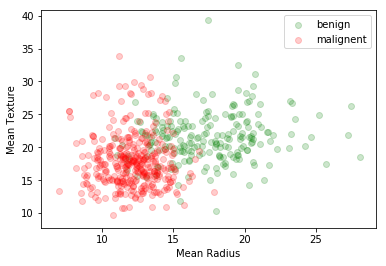

In [7]:
xb,yb=benign[:,0],benign[:,1]
xm,ym=malignent[:,0],malignent[:,1]
plt.scatter(xb,yb,color='g',alpha=0.2,label='benign')
plt.scatter(xm,ym,color='r',alpha=0.2,label='malignent')
plt.legend()
plt.xlabel("Mean Radius")
plt.ylabel("Mean Texture")
plt.show()

## Decision Tree set up

Setting up tree functions for splitting

In [8]:
class DecisionTree:
    def __init__(self,max_depth,min_size):
        """Decision Tree class with user inputs to control run length of:
            max_depth: user specified maximum cutoff depth of tree,
            min_size: user specified minimum depth of tree."""
        self.max_depth = max_depth
        self.min_size = min_size
    
    def split(self,index,value,data):
        """Given a threshold value, perform a split on the data in 2 parts."""
        split1 = []
        split2 = []
        for row in data:
            if row[index] < value:
                split1.append(row)
            else:
                split2.append(row)
        return split1, split2

    def gini(self,groups,classes):
        """Calculates the gini score for a given splitting choice.
            The score indicates how good the split is by calculating the proportion of correctly subdivided classes.
            A score is between 0 and 1, with 0 being the best."""
        total = sum([len(group) for group in groups])
        gini = 0
        for group in groups:
            size = len(group)
            if size == 0:
                continue
            score = 0
            for class_value in classes:
                proportion = [row[-1] for row in group].count(class_value) / size
                score += proportion*proportion 
            gini += (1.0 - score) * (size / total) 
        return gini


    def find_split(self,data):
        """Iterates through different splits to find the optimum splitting given the gini score."""
        class_values = set(row[-1] for row in data)
        b_index, b_value, b_score, b_groups = 999, 999, 999, None
        for index in range(len(data[0])-1):
            for row in data:
                groups = self.split(index,row[index],data)
                gini_score = self.gini(groups,class_values)
                #print('X%d < %.3f Gini=%.3f' % ((index+1), row[index], gini_score))
                if gini_score < b_score:
                    b_index, b_value, b_score, b_groups = index, row[index], gini_score, groups
        return {'index':b_index, 'value':b_value, 'groups':b_groups}
    
    def terminal_value(self,group):
        """Given the values at a final (terminal) node, calculates
            the chosen value (i.e. most likely occuring value)."""
        outcomes = [row[-1] for row in group]
        return max(set(outcomes), key = outcomes.count)

    def child_split(self,node,depth):
        """Splits the node into child nodes. Inputs:
            node: current working node,
            depth: current working depth."""

        split1, split2 = node['groups']
        del(node['groups'])

        #check if splits are empty
        if len(split1) == 0 or len(split2) == 0:
            node['split1'] = node['split2'] = self.terminal_value(split1 + split2)
            return

        #check max depth
        if depth >= self.max_depth:
            node['split1'], node['split2'] = self.terminal_value(split1), self.terminal_value(split2)
            return

        #split1
        if len(split1) <= self.min_size:
            node['split1'] = self.terminal_value(split1)
        else:
            node['split1'] = self.find_split(split1)
            self.child_split(node['split1'],depth+1)

        #split2
        if len(split2) <= self.min_size:
            node['split2'] = self.terminal_value(split2)
        else:
            node['split2'] = self.find_split(split2)
            self.child_split(node['split2'],depth+1)
            
    def build(self,train):
        """Builts the decision tree."""

        #create root node from which to split
        root = self.find_split(train)
        self.child_split(root,depth=1)
        return root
    
    def predict(self,node,row):
        """Predicts the class given a row of data by following a 
            path through the tree until terminal nodes are reached."""
        #check data values against threshold
        if row[node['index']] < node['value']:
            #check if split1 node is in a nodal dictionary or if it is a terminal node
            if isinstance(node['split1'], dict):
                return self.predict(node['split1'], row)
            else:
                #if temrinal node, then split1 will have the terminal value assigned by the child_split function
                return node['split1']

        #check if split2 node is in a nodal dictionary or if it is a terminal node
        else:
            if isinstance(node['split2'], dict):
                return self.predict(node['split2'], row)
            else:
                #if temrinal node, then split2 will have the terminal value assigned by the child_split function
                return node['split2']

Define the accuracy of the model

In [33]:
def accuracy(target, prediction):
    """Calculates the accuracy of the model."""
    correct = 0
    for i in range(len(target)):
        if target[i] == prediction [i]:
            correct += 1
    accuracy = float(float(correct) / float((len(target))))
    return accuracy

## Test on the data

In [19]:
train = dataset[:500]
test = dataset[500:569]
target = [row[-1] for row in test]

In [20]:
DT = DecisionTree(10,1)

Build the model

In [21]:
tree = DT.build(train)

Test predictions

In [22]:
predictions = []
for row in test:
    predictions.append(DT.predict(tree,row))

In [34]:
print (accuracy(target,predictions))

0.826086956522


For more information: https://machinelearningmastery.com/implement-decision-tree-algorithm-scratch-python/